# Movie Recommendation System using NLP

In [1]:
#Import Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# Libraries required for NLP
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
import string
from requests import get

# Library for Collaborative filtering
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
movies_metadata = pd. read_csv('movies_metadata.csv')
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


##### Features
- adult: Indicates if the movie is X-Rated or Adult.
- belongs_to_collection: A stringified dictionary that gives information on the movie series the particular film belongs to.
- budget: The budget of the movie in dollars.
- genres: A stringified list of dictionaries that list out all the genres associated with the movie.
- homepage: The Official Homepage of the move.
- id: The ID of the movie.
- imdb_id: The IMDB ID of the movie.
- original_language: The language in which the movie was originally shot in.
- original_title: The original title of the movie.
- overview: A brief blurb of the movie.
- popularity: The Popularity Score assigned by TMDB.
- poster_path: The URL of the poster image.
- production_companies: A stringified list of production companies involved with the making of the movie.
- production_countries: A stringified list of countries where the movie was shot/produced in.
- release_date: Theatrical Release Date of the movie.
- revenue: The total revenue of the movie in dollars.
- runtime: The runtime of the movie in minutes.
- spoken_languages: A stringified list of spoken languages in the film.
- status: The status of the movie (Released, To Be Released, Announced, etc.)
- tagline: The tagline of the movie.
- title: The Official Title of the movie.
- video: Indicates if there is a video present of the movie with TMDB.
- vote_average: The average rating of the movie.
- vote_count: The number of votes by users, as counted by TMDB.

In [4]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

we have more than 45,000 movies in the movies-metadata

Lets Explore the dataset !

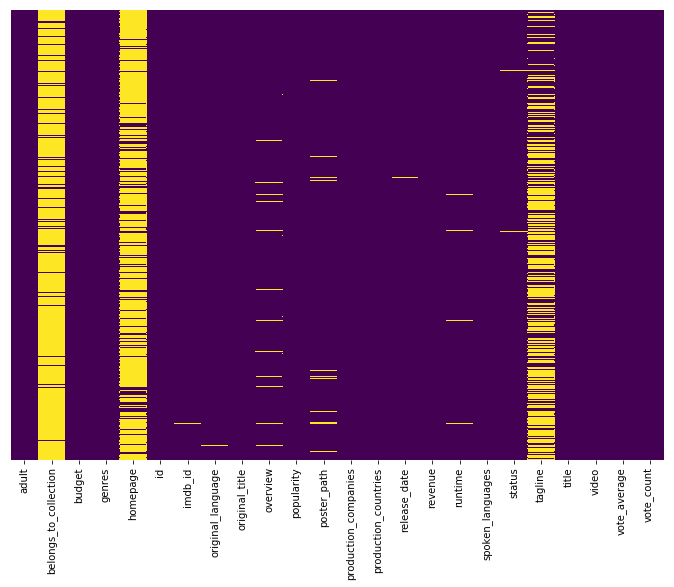

In [5]:
#Null Value Analysis
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.heatmap(movies_metadata.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax)

Form the above graph, We can easily visualize how much data is missing for our dataset, We have more than 80% of missing data for homepage, tagline, belongs_to_collection

In [6]:
#Reading the movies from our small movies data set
movies_small = pd.read_csv('movies.csv')
movies_small.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
title      9125 non-null object
genres     9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


We have 9125 movies in the movies small dataset, lets reduce the size of movies metadata, so that movies metadata contains info of only movies small dataset

In [8]:
#Checking Null values
movies_small.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

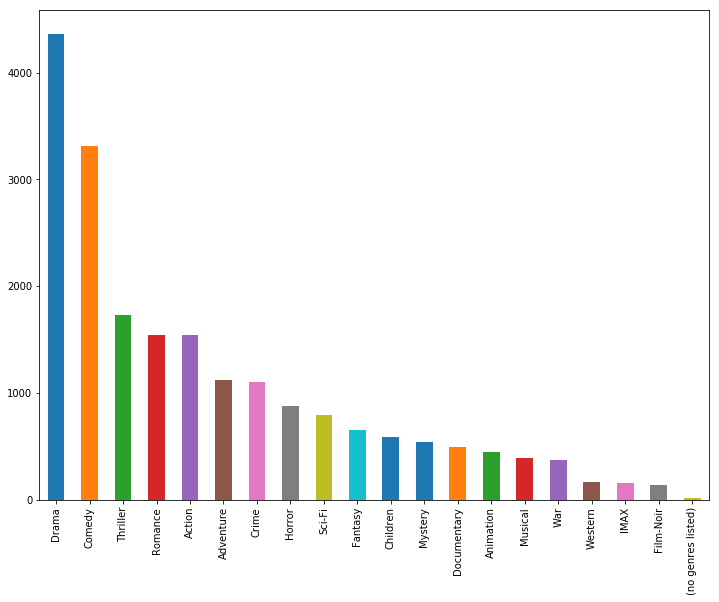

In [9]:
# Creating a plot for Genre Distribution
df1 = movies_small['genres'].apply(lambda genrelist : str(genrelist).split("|"))
df1 = pd.Series(df1).apply(frozenset).to_frame(name='givengenres')
for givengenres in frozenset.union(*df1.givengenres):
    df1[givengenres] = df1.apply(lambda _: int(givengenres in _.givengenres), axis=1)
df1.drop('givengenres',axis=1,inplace=True)
df1['movieId']=movies_small['movieId']
df1 = pd.merge(movies_small,df1,on='movieId')
df1.head()
genre_columns= ['Film-Noir',
       'Romance', 'Western', 'Documentary', 'Thriller', 'Action', 'Musical',
       'War', 'Drama', 'IMAX', 'Crime', 'Children', 'Adventure', 'Horror',
       'Fantasy', 'Animation', 'Comedy', 'Mystery', '(no genres listed)',
       'Sci-Fi']
df1[genre_columns].sum().sort_values(ascending=False).plot(kind='bar',figsize=(12,9))

We can see from the above graph that majority of the movies are of genre Drama and Comedy

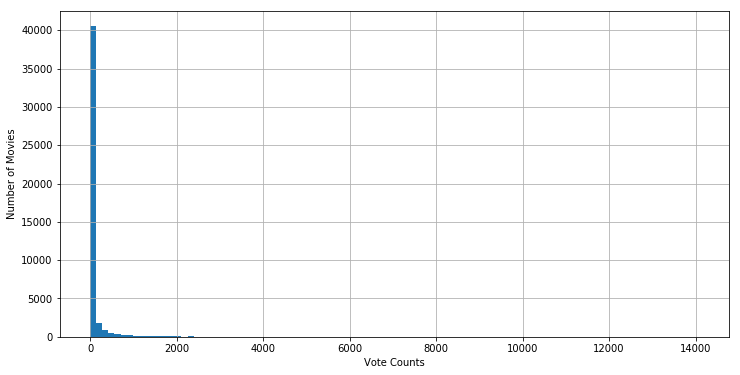

In [10]:
# Plotting a graph to see the distribution of votes across
plt.subplots(figsize=(12,6))
ax = movies_metadata['vote_count'].hist(bins=100)
plt.xlabel('Vote Counts')
plt.ylabel('Number of Movies')
plt.show()

From here, we can infer that most movies have vote counts in the range of 0-500

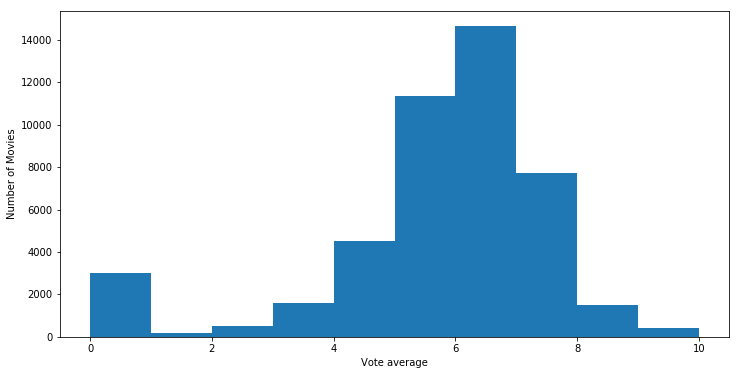

In [11]:
# Lets look into the distribution of vote average for out movies dataset
plt.subplots(figsize=(12,6))
ax = movies_metadata['vote_average'].plot(kind='hist')
plt.xlabel('Vote average')
plt.ylabel('Number of Movies')
plt.show()

From the above graph we can see that most of movies have vote average between 5 to 7

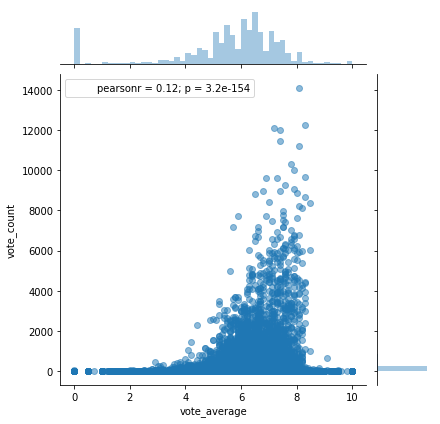

In [12]:
# Lets create a join plot to see the vote counts and vote average distribution
sns.jointplot(x='vote_average',y='vote_count',data=movies_metadata,alpha=0.5)

From here we can infer tha movies which have higher rating has higher vote counts, Naturally because more people watch and rate popular movies

In [13]:
links = pd.read_csv('links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
imdbId     9125 non-null int64
tmdbId     9112 non-null float64
dtypes: float64(1), int64(2)
memory usage: 213.9 KB


In [15]:
#Checking Null Values
links.isnull().sum()

movieId     0
imdbId      0
tmdbId     13
dtype: int64

In [16]:
movies_metadata.id.isnull().sum()

0

In [17]:
links.tmdbId.isnull().sum()

13

In [18]:
#Since we are using movies small dataset, we will only keep values in movies_metadata for movies in movies_small
movies_metadata = movies_metadata[movies_metadata.id.isin(links['tmdbId'].astype(str).apply(lambda x:x[:-2]).tolist())]

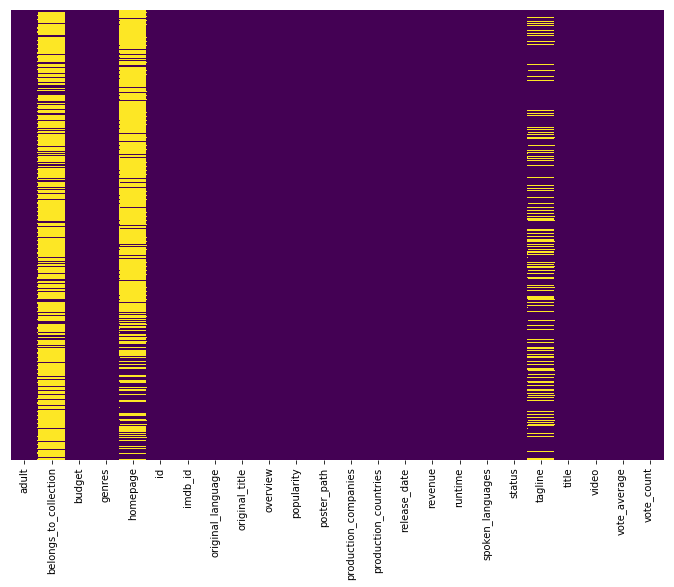

In [19]:
#Lets look at the null values after we have created this smaller version of movies_metadata
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.heatmap(movies_metadata.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax)

In [20]:
#Creating a list of genres from the json format provided
movies_metadata['genres'] = movies_metadata['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

We also need to add Movie Id to our movies metadata, we can do it through links.csv

In [21]:
def convert_int(x):
    try:
        return int(x) 
    except:
        return 0

In [22]:
links['tmdbId'] = links['tmdbId'].apply(convert_int)

In [23]:
movies_metadata['id'] = movies_metadata['id'].apply(convert_int)

In [24]:
def return_movieId(tmdbId):
    return links[links['tmdbId']==tmdbId]['movieId'].iloc[0]

In [25]:
#Get movie Id to the movies_metadata
movies_metadata['movieId'] = movies_metadata['id'].apply(return_movieId)
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,2
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,3
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,5


In [26]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9099 entries, 0 to 45265
Data columns (total 25 columns):
adult                    9099 non-null object
belongs_to_collection    1674 non-null object
budget                   9099 non-null object
genres                   9099 non-null object
homepage                 1974 non-null object
id                       9099 non-null int64
imdb_id                  9099 non-null object
original_language        9099 non-null object
original_title           9099 non-null object
overview                 9087 non-null object
popularity               9099 non-null object
poster_path              9096 non-null object
production_companies     9099 non-null object
production_countries     9099 non-null object
release_date             9099 non-null object
revenue                  9099 non-null float64
runtime                  9099 non-null float64
spoken_languages         9099 non-null object
status                   9097 non-null object
tagline          

I use the TMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) =  (vv+m.R)+(mv+m.C) 
where,

v is the number of votes for the movie
m is the minimum votes required to be listed in the chart
R is the average rating of the movie
C is the mean vote across the whole report
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

<<<<< enter link for IMDB weighted rating here


In [27]:
no_of_votes = movies_metadata[movies_metadata['vote_count'].notnull()]['vote_count'].astype('int')
vote_mean = movies_metadata[movies_metadata['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_mean.mean()
C

5.916804044400483

In [28]:
m = no_of_votes.quantile(0.95)
m

2079.1000000000004

In [29]:
# Adding year column based on movies release date
movies_metadata['year'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [30]:
movies_metadata['year'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
top_movies = movies_metadata[(movies_metadata['vote_count'] >= m) & (movies_metadata['vote_count'].notnull()) & (movies_metadata['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
top_movies['vote_count'] = top_movies['vote_count'].astype('int')
top_movies['vote_average'] = top_movies['vote_average'].astype('int')
top_movies.shape

(455, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least 2079 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.916 on a scale of 10. 455 Movies qualify to be on our chart.

In [31]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [32]:
top_movies['wr'] = top_movies.apply(weighted_rating, axis=1)

In [33]:
top_movies = top_movies.sort_values('wr', ascending=False).head(100)

In [34]:
top_movies.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.731884
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.698136
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.673516
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.631612
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.605220
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.597066
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.585021
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.579706
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.576459
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.554411


In [35]:
y = movies_metadata.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
y.name = 'genre'
gen_data = movies_metadata.drop('genres', axis=1).join(y)

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the 85th percentile instead of 95.

In [36]:
def top_movies_genre(genre, percentile=0.85):
    df = gen_data[gen_data['genre'] == genre]
    no_of_votes = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_mean = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_mean.mean()
    m = no_of_votes.quantile(percentile)
    
    top_movies = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    top_movies['vote_count'] = top_movies['vote_count'].astype('int')
    top_movies['vote_average'] = top_movies['vote_average'].astype('int')
    
    top_movies['wr'] = top_movies.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    top_movies = top_movies.sort_values('wr', ascending=False).head(250)
    
    return top_movies

Lets look upon Top 10 animation movies

In [37]:
top_movies_genre('Animation').head(10)

,title,year,vote_count,vote_average,popularity,wr
359,The Lion King,1994,5520,8,21.6058,7.592229
5481,Spirited Away,2001,3968,8,41.0489,7.481030
9698,Howl's Moving Castle,2004,2049,8,16.136,7.217022
2884,Princess Mononoke,1997,2041,8,17.1667,7.215358
5833,My Neighbor Totoro,1988,1730,8,13.5073,7.144693
13724,Up,2009,7048,7,19.3309,6.859731
30315,Inside Out,2015,6737,7,23.9856,6.854574
15472,Despicable Me,2010,6595,7,22.2745,6.852092
12704,WALL·E,2008,6439,7,16.0884,6.849265
6232,Finding Nemo,2003,6292,7,25.4978,6.846500


## Content Based Recommender
The simple recommender that we just built provides just the top results for the genre, and it shows the the same results for every user looking for that genre.

It also dosen't account for fan following towards particular director or Actors, which accounts for people also watching the movies that are less popular but from famous actors and directors.

For personalized recommendations, We will create a recommendation system that computes similarity between movies based on certain features and recommend movies that are similar to user's taste. As we are using movie's metadata (or content) for creating this system, it is also referred as Content Based Filtering.

We will build four Content Based Recommenders based on:

- Movie overview's that particular user has liked and use latent semantic similarity for comparing similar movies
- Adding Taglines and Movie Overviews and compare using pairwise cosine similarity
- Movie Cast, Crew, Keywords and Genre


#### Movie Description Based Recommender
Let us first try to build a recommender using movie descriptions and taglines. We do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively.

In [38]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,2,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,3,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,5,1995


For our first attempt in building Description based recommendation system,
- We will first take list of movies which a user has watched
- Process the description of the movie using NLP techniques like removing stopwords and punctuations, applying Tokenization, lemmatization and stemming, and return a clean list of words
- Using similar techniques, we will process the description/overview of movie in our movies_metadata for the top 80 percentile of movies
- In the next step, we will calculate the similarity between the combined overview of the movies user has watched and the overview of the movies user hasn't watched
- To get this similarity, we will use UMBC's API service to provide latent semantic similarity between 2 scentences. The link to which can be found [here](http://swoogle.umbc.edu/SimService/api.html)

Lets get the top movies that a user has rated more than average

In [39]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [40]:
#Get movieId for above average ratings for userId 1
ratings[(ratings['userId']==1) & (ratings['rating']>2.5)]['movieId'].tolist()

[1029, 1061, 1172, 1339, 1953, 2105, 2150, 3671]

In [41]:
def text_process(mess):
    """
    1. remove punc
    2. remove stop words
    3. apply lemmatization
    4. apply stemmization
    5. return list clean overview
    
    """
    #Remove Stopwords and punctuations
    nopunc = [char for char in mess if char not in string.punctuation]
    stopwords = nltk.corpus.stopwords.words('english')
    nopunc = ''.join(nopunc)
    
    #Apply tokenization
    tokenized_list = []
    tokenized_list =  [word for word in nopunc.split() if word.lower() not in stopwords]
    
    
    wordnet_lemmatizer = WordNetLemmatizer()
    snowball_stemmer = SnowballStemmer('english')

    #Applying Lemmatization
    
    lemmatized_words = []
    for word in tokenized_list:
        lemmatized_words.append(wordnet_lemmatizer.lemmatize(word))

   #Applying Stemmization
   
    cleaned_list  = []
    for word in lemmatized_words:
        cleaned_list.append(snowball_stemmer.stem(word))
    return ' '.join(cleaned_list)

In [42]:
movies_metadata['overview'] = movies_metadata['overview'].astype(str)

In [43]:
movies_metadata['pro_overview'] = movies_metadata['overview'].apply(text_process)

In [44]:
percentile = 0.90
no_of_votes = movies_metadata[movies_metadata['vote_count'].notnull()]['vote_count'].astype('int')
vote_mean = movies_metadata[movies_metadata['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_mean.mean()
m = no_of_votes.quantile(percentile)

top_movies = movies_metadata[(movies_metadata['vote_count'] >= m) & (movies_metadata['vote_count'].notnull()) & (movies_metadata['vote_average'].notnull())][['movieId','title', 'year', 'vote_count', 'vote_average', 'popularity','pro_overview']]
top_movies['vote_count'] = top_movies['vote_count'].astype('int')
top_movies['vote_average'] = top_movies['vote_average'].astype('int')

In [45]:
top_movies.sort_values(by='vote_count',ascending=False).head()

,movieId,title,year,vote_count,vote_average,popularity,pro_overview
15480,79132,Inception,2010,14075,8,29.1081,cobb skill thief commit corpor espionag infilt...
12481,58559,The Dark Knight,2008,12269,8,123.167,batman rais stake war crime help lt jim gordon...
14551,72998,Avatar,2009,12114,7,185.071,22nd centuri parapleg marin dispatch moon pand...
17818,89745,The Avengers,2012,12000,7,89.8876,unexpect enemi emerg threaten global safeti se...
26564,122904,Deadpool,2016,11444,7,187.86,deadpool tell origin stori former special forc...


In [46]:
len(top_movies)

910

In [47]:
sss_url = "http://swoogle.umbc.edu/SimService/GetSimilarity"

def sss(s1, s2, type='relation', corpus='webbase'):
    try:
        response = get(sss_url, params={'operation':'api','phrase1':s1,'phrase2':s2,'type':type,'corpus':corpus})
        return float(response.text.strip())
    except:
        #print ('Error in getting similarity for %s: %s' % ((s1,s2), response))
        return 0.0

In [48]:
user_1_movies=[]
for movieId in ratings[(ratings['userId']==1) & (ratings['rating']>2.5)]['movieId'].tolist():
    user_1_movies.append(movies_metadata[movies_metadata['movieId']==movieId]['pro_overview'].iloc[0])
user_1_movies = ' '.join(user_1_movies)

In [49]:
user_1_movies

'dumbo babi eleph born overs ear suprem lack confid thank even diminut buddi timothi mous pintsiz pachyderm learn surmount obstacl two gangster seek reveng state jail worker stay youth prison sexual abus sensat court hear take place charg crime move drama director barri levinson filmmak recal childhood fell love movi villag theater form deep friendship theater projectionist dracula leaf captiv jonathan harker transylvania london search mina harker spit imag dracula longdead wife elisabeta obsess vampir hunter dr van hels set end mad tough narcot detect popey doyl hot pursuit suav french drug dealer may key huge heroinsmuggl oper kevin flynn search proof invent hit video game digit laser find insid grid program suffer tyrann rule master control program help tron secur program flynn seek free grid mcp miseri brought small group sho kalahari desert form cola bottl quest throw evil object edg earth xixo encount western civil haphazard doctor tyran despot town – everyon seem name johnson – 

In [50]:
%%time
top_movies['similarity'] = top_movies['pro_overview'].apply(lambda x:sss(user_1_movies,x))

Wall time: 4min 42s


In [51]:
top_movies.head()

,movieId,title,year,vote_count,vote_average,popularity,pro_overview,similarity
0,1,Toy Story,1995,5415,7,21.9469,led woodi andi toy live happili room andi birt...,0.234470
1,2,Jumanji,1995,2413,6,17.0155,sibl judi peter discov enchant board game open...,0.270828
5,6,Heat,1995,1886,7,17.9249,obsess master thief neil mccauley lead topnotc...,0.221906
9,10,GoldenEye,1995,1194,6,14.686,jame bond must unmask mysteri head janus syndi...,0.153685
15,16,Casino,1995,1343,7,10.1374,life gambl paradis – las vega – dark mafia und...,0.092047


In [52]:
top_movies[top_movies.movieId.isin(ratings[ratings['userId']!=1]['movieId'].tolist())][['title','similarity','vote_count','vote_average']].sort_values(by='similarity',ascending=False).head(10)

,title,similarity,vote_count,vote_average
1000,Dumbo,0.587255,1206,6
20971,Epic,0.365386,1143,6
892,The Wizard of Oz,0.362549,1689,7
18973,Snow White and the Huntsman,0.361434,3183,5
24939,Dumb and Dumber To,0.361130,1140,5
16279,TRON: Legacy,0.356697,2895,6
9430,Oldboy,0.340289,2000,8
18499,Chronicle,0.340005,1965,6
19825,Rise of the Guardians,0.337160,1981,7
24278,Dracula Untold,0.333092,2439,6


In [53]:
#lets create a recommender based on the above method

In [54]:
def user_taste_recommender(userId,percentile = 0.90):
    no_of_votes = movies_metadata[movies_metadata['vote_count'].notnull()]['vote_count'].astype('int')
    vote_mean = movies_metadata[movies_metadata['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_mean.mean()
    m = no_of_votes.quantile(percentile)

    top_movies = movies_metadata[(movies_metadata['vote_count'] >= m) & (movies_metadata['vote_count'].notnull()) & (movies_metadata['vote_average'].notnull())][['movieId','title', 'year', 'vote_count', 'vote_average', 'popularity','pro_overview']]
    top_movies['vote_count'] = top_movies['vote_count'].astype('int')
    top_movies['vote_average'] = top_movies['vote_average'].astype('int')
    
    user_movies=[]
    for movieId in ratings[(ratings['userId']==userId) & (ratings['rating']>2.5)]['movieId'].tolist():
        user_movies.append(movies_metadata[movies_metadata['movieId']==movieId]['pro_overview'].iloc[0])
    user_movies = ' '.join(user_movies)
    
    top_movies['similarity'] = top_movies['pro_overview'].apply(lambda x:sss(user_movies,x))
    top_movies = top_movies[top_movies.movieId.isin(ratings[ratings['userId']!=userId]['movieId'].tolist())][['title','similarity','vote_count','vote_average']].sort_values(by='similarity',ascending=False).head(10)
    
    return top_movies

In [55]:
user_taste_recommender(100)

,title,similarity,vote_count,vote_average
600,Fargo,0.622953,2080,7
31,Twelve Monkeys,0.619132,2470,7
760,Independence Day,0.589538,3334,6
0,Toy Story,0.589521,5415,7
716,The Rock,0.585872,1474,6
638,Mission: Impossible,0.572218,2677,6
5,Heat,0.572186,1886,7
375,True Lies,0.478509,1138,6
21068,Man of Steel,0.446365,6462,6
892,The Wizard of Oz,0.445946,1689,7


Just getting recommendation based on movie's synopsis dosent provide eye catching results, and is not reliable enough as Latent Semantic Similarity here takes into account movies from all the genre and most importantly, takes lot of time to calculate through the UMBC's API for soo many movies, So we will try Consine similarity from sklearn's linear kernel which is much faster to calculate

Also, lets add tagline to the description and check if we get better recommendations

In [56]:
movies_metadata['tagline'] = movies_metadata['tagline'].fillna('')
movies_metadata['description'] = movies_metadata['pro_overview'] + movies_metadata['tagline']
movies_metadata['description'] = movies_metadata['description'].fillna('')

In [57]:
movies_metadata['description'].head()

0    led woodi andi toy live happili room andi birt...
1    sibl judi peter discov enchant board game open...
2    famili wed reignit ancient feud nextdoor neigh...
3    cheat mistreat step woman hold breath wait elu...
4    georg bank recov daughter wed receiv news shes...
Name: description, dtype: object

In [58]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_metadata['description'])

In [59]:
tfidf_matrix.shape

(9099, 264045)

#### Cosine Similarity
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

cosine(x,y)=x.y⊺||x||.||y|| 
Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [60]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [61]:
cosine_sim[0]

array([1.        , 0.00973524, 0.        , ..., 0.        , 0.0025085 ,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [62]:
movies_metadata = movies_metadata.reset_index()
titles = movies_metadata['title']
indexes = pd.Series(movies_metadata.index, index=movies_metadata['title'])

In [63]:
#To get pairwise similarity score for movie with index 0
similarity =  list(enumerate(cosine_sim[0]))
print(similarity)

[(0, 0.9999999999999999), (1, 0.009735244938882703), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.007144671375121861), (17, 0.012421438495096492), (18, 0.0), (19, 0.0), (20, 0.0032737736480710263), (21, 0.0), (22, 0.0026527105730075108), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.006927272014702977), (33, 0.0), (34, 0.0), (35, 0.0035167174530869173), (36, 0.010488082480031125), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (41, 0.0034977367551689933), (42, 0.0), (43, 0.0), (44, 0.0030982705983496612), (45, 0.0), (46, 0.0), (47, 0.0), (48, 0.00637987862737388), (49, 0.00860089206570781), (50, 0.0), (51, 0.0), (52, 0.01381816544846436), (53, 0.006221480968027278), (54, 0.006386218333823071), (55, 0.0), (56, 0.015151913271517992), (57, 0.0), (58, 0.0), (59, 0.0049107586769808935), (60, 0.0), (61, 0.0027304141668222197), (6

In [64]:
def desc_based_recommendation(title):
    idx = indexes[title]
    sim = list(enumerate(cosine_sim[idx]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    sim = sim[1:31]
    rec_movies_indexes = [i[0] for i in sim]
    return titles.iloc[rec_movies_indexes]

Lets get reccomendation for star wars

In [65]:
desc_based_recommendation('Star Wars').head(10)

949          The Empire Strikes Back
962               Return of the Jedi
8755    Star Wars: The Force Awakens
6690                 Shrek the Third
7539             Shrek Forever After
4815               Where Eagles Dare
2890                   Shanghai Noon
5383                         Shrek 2
5088             The Thief of Bagdad
279                The Swan Princess
Name: title, dtype: object

We get Return of Jedi and Star Wars: The Force Awakens as a recommendation for star wars which is pretty cool!

#### Metadata Based Recommender

Lets add more details like cast, crew , directors, keywords etc to get better similarity score for movies with similar content.
To do the same we need to prepare this data as our first step.

In [66]:
#loading data from credits.csv for cast and crew, and Keywords.csv for keywords related to movies
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [67]:
#Converting id's to int
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies_metadata['id'] = movies_metadata['id'].astype('int')

In [68]:
# Add Cast and Crew column to our movies dataset
movies_metadata = movies_metadata.merge(credits, on='id')
#Add Keywords to the dataset
movies_metadata = movies_metadata.merge(keywords, on='id')

In [69]:
movies_metadata.head()

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,video,vote_average,vote_count,movieId,year,pro_overview,description,cast,crew,keywords
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,False,7.7,5415.0,1,1995,led woodi andi toy live happili room andi birt...,led woodi andi toy live happili room andi birt...,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,...,False,6.9,2413.0,2,1995,sibl judi peter discov enchant board game open...,sibl judi peter discov enchant board game open...,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,False,6.5,92.0,3,1995,famili wed reignit ancient feud nextdoor neigh...,famili wed reignit ancient feud nextdoor neigh...,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,...,False,6.1,34.0,4,1995,cheat mistreat step woman hold breath wait elu...,cheat mistreat step woman hold breath wait elu...,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,...,False,5.7,173.0,5,1995,georg bank recov daughter wed receiv news shes...,georg bank recov daughter wed receiv news shes...,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


After getting the data in a single dataframe, we can get the following from the data:
<p><b> Crew:</b>
Since director is the most important person in the crew of the movie, we will take it as our feature from the crew
<p><b>  Cast: </b>
We will take the first 3 actors from the Cast

In [70]:
#Checking for Python literal structures: strings, bytes, numbers, tuples, lists, dicts, sets, booleans, and None.
movies_metadata['cast'] = movies_metadata['cast'].apply(literal_eval)
movies_metadata['crew'] = movies_metadata['crew'].apply(literal_eval)
movies_metadata['keywords'] = movies_metadata['keywords'].apply(literal_eval)
#Get the cast and crew size
movies_metadata['cast_size'] = movies_metadata['cast'].apply(lambda x: len(x))
movies_metadata['crew_size'] = movies_metadata['crew'].apply(lambda x: len(x))

In [71]:
def get_director(d):
    for i in d:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [72]:
movies_metadata['director'] = movies_metadata['crew'].apply(get_director)

In [73]:
movies_metadata['cast'] = movies_metadata['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_metadata['cast'] = movies_metadata['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [74]:
movies_metadata['keywords'] = movies_metadata['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

We will add genre, keywords, director and main actors and create count matrix using count vectorizer as we did in Description based recommender and follow similar steps to calculate cosine similarities to get most similar movies.

- Remove Spaces between names
- Convert all features to lower case
- This will help to distinguish between Christopher Nolen and Christopher Columbus
- To get movies with same director more often, we will add director 3 times and provide additional weight to this feature

In [75]:
movies_metadata['cast'] = movies_metadata['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [76]:
#Remove spaces between names
movies_metadata['director'] = movies_metadata['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
#Add more weight to director
movies_metadata['director'] = movies_metadata['director'].apply(lambda x: [x,x, x])

<b>Keywords:</b>
We only require keywords that occur more than once, having keywords that occur just once will increase complexity and reduce similarity score. So let's count the keywords and keep only those occuring more than once

In [77]:
k = movies_metadata.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
k.name = 'keyword'

In [78]:
k = k.value_counts()
k[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [79]:
#Removing keyword occuring just once
k = k[k > 1]

Using Snowball Stemmer, lets take the word back to its root form. This helps to reduce same features like forest and forests

In [80]:
stemmer = SnowballStemmer('english')
stemmer.stem('forests')

'forest'

In [81]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in k:
            words.append(i)
    return words

In [82]:
movies_metadata['keywords'] = movies_metadata['keywords'].apply(filter_keywords)
movies_metadata['keywords'] = movies_metadata['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
movies_metadata['keywords'] = movies_metadata['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [83]:
movies_metadata['analyzer'] = movies_metadata['keywords'] + movies_metadata['cast'] + movies_metadata['director'] + movies_metadata['genres']
movies_metadata['analyzer'] = movies_metadata['analyzer'].apply(lambda x: ' '.join(x))

In [84]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(movies_metadata['analyzer'])

In [85]:
# Get pairwise cosine similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [86]:
movies_metadata = movies_metadata.reset_index()
titles = movies_metadata['title']
indexes = pd.Series(movies_metadata.index, index=movies_metadata['title'])

In [87]:
desc_based_recommendation('Star Wars').head(10)

2120       Star Wars: Episode I - The Phantom Menace
4137    Star Wars: Episode II - Attack of the Clones
6199    Star Wars: Episode III - Revenge of the Sith
970                          The Empire Strikes Back
4789                                        THX 1138
983                               Return of the Jedi
2705                               American Graffiti
7088                       Star Wars: The Clone Wars
8865                    Star Wars: The Force Awakens
8079                Journey 2: The Mysterious Island
Name: title, dtype: object

We get much better results this time, most of the star war related movies are covered. Let's try for another movie 'Inception'

In [88]:
desc_based_recommendation('Inception').head(10)

6623                             The Prestige
3381                                  Memento
4145                                 Insomnia
2085                                Following
8031                    The Dark Knight Rises
8613                             Interstellar
6981                          The Dark Knight
6218                            Batman Begins
5638    Sky Captain and the World of Tomorrow
8500                                  Don Jon
Name: title, dtype: object

This proves that adding weight to the director definetly works, as most of the movies in Top 10 is of Christopher Nolan

#### Popularity Based Recommendation
Since our current recommender dosen't take popularity and ratings into account, it shows movies like 'Sky Captain and the World of Tomorrow' over many other popular movies.

We will improve our recommendation system by returning only popular movies with more number of ratings

let's take top 25 movies based on similarity scores and calculate the vote of the 70th percentile movie. Then, using this as the value of  m , we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [89]:
def popularity_based_recommendations(title,percentile=0.70):
    idx = indexes[title]
    sim = list(enumerate(cosine_sim[idx]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    sim = sim[1:26]
    req_index = [i[0] for i in sim]
    
    movies = movies_metadata.iloc[req_index][['title', 'vote_count', 'vote_average', 'year']]
    no_of_votes = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_mean = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    m = no_of_votes.quantile(percentile)
    C = vote_mean.mean()
    top_movies = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    top_movies['vote_count'] = top_movies['vote_count'].astype('int')
    top_movies['vote_average'] = top_movies['vote_average'].astype('int')
    top_movies['wr'] = top_movies.apply(weighted_rating, axis=1)
    top_movies = top_movies.sort_values('wr', ascending=False).head(10)
    return top_movies

In [90]:
popularity_based_recommendations('Star Wars')

,title,vote_count,vote_average,year,wr
970,The Empire Strikes Back,5998,8,1980,7.671623
8865,Star Wars: The Force Awakens,7993,7,2015,6.866624
983,Return of the Jedi,4763,7,1983,6.793425
6199,Star Wars: Episode III - Revenge of the Sith,4200,7,2005,6.771573
7600,Iron Man 2,6969,6,2010,5.988459
8581,Divergent,4784,6,2014,5.984190
2120,Star Wars: Episode I - The Phantom Menace,4526,6,1999,5.983468
3049,X-Men,4172,6,2000,5.982363


We get even better recommendation using popularity based recommender, as we get X-Men and Iron Man 2 in the list , which are my favourites 

#### Collaborative Filtering*
The Results from our popularity based recommender are impressive, we get most of the similar movies when querying for a movie. While content based are good when we have good amount of content for the movie like the name of actors, movie synopsis, director’s information etc. we always don’t have all the information required for making relevant recommendations. Also, while we tried to derive user’s taste by using movies overview and taglines as input to our model, the recommendations provided by a collaborative filtering model are way better than a content based model. Another advantage of using a collaborative filtering model over Content based model is that it doesn’t require any data related to movies content. We have built a CF model using Scikit learn’s Surprise library which provides a simple data ingestion for making recommendations through CF. It also provides powerful algorithms like Singular Value Decomposition(SVD) to minimize RMSE and provide great recommendations.

*The code for Collaborative filtering is referred from Rounak Banik's Github Repository which can be accessed [here](https://github.com/rounakbanik/movies/blob/master/movies_recommender.ipynb)

In [91]:
reader = Reader()

In [92]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [93]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [94]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9016
MAE:  0.6928
------------
Fold 2
RMSE: 0.9004
MAE:  0.6939
------------
Fold 3
RMSE: 0.8917
MAE:  0.6884
------------
Fold 4
RMSE: 0.8999
MAE:  0.6904
------------
Fold 5
RMSE: 0.8911
MAE:  0.6865
------------
------------
Mean RMSE: 0.8969
Mean MAE : 0.6904
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.6927538693365773,
                             0.693911637711029,
                             0.6883683654884518,
                             0.6903754461245644,
                             0.6865100330611149],
                            'rmse': [0.9016342233871928,
                             0.900402697676928,
                             0.8917022443974216,
                             0.8998581438416187,
                             0.8911292005047662]})

We get a mean Root Mean Sqaure Error of 0.8951 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [95]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [96]:
#Provide userId, movieId and True Rating
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7450032112214804, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 2.862. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

#### Hybrid Recommender*

Hybrid Recommender leverages the best of both Content based and collaborative filtering techniques.

Input: User ID and the Title of a Movie
Output: Similar movies sorted on the basis of expected ratings by that particular user.

*Part of code for Hybrid Recommendation is referred from Rounak Banik's Github Repository which can be accessed from [here](https://github.com/rounakbanik/movies/blob/master/movies_recommender.ipynb)

In [97]:
links.drop('imdbId',axis=1,inplace=True)
links.columns=['movieId', 'id']
id_map = links.merge(movies_metadata[['title', 'id']], on='id').set_index('title')

In [98]:
indices_map = id_map.set_index('id')

In [109]:
def hybrid(userId, title):
    idx = indexes[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_metadata.iloc[movie_indices][['title', 'vote_count','year', 'id']]
    movies['est rating'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est rating', ascending=False)
    return movies.head(10)

In [110]:
hybrid(1, 'Avatar')

,title,vote_count,year,id,est rating
1011,The Terminator,4208.0,1984,218,3.113663
522,Terminator 2: Judgment Day,4274.0,1991,280,3.099023
974,Aliens,3282.0,1986,679,2.979387
8658,X-Men: Days of Future Past,6155.0,2014,127585,2.894395
8401,Star Trek Into Darkness,4479.0,2013,54138,2.874042
2014,Fantastic Planet,140.0,1973,16306,2.820920
344,True Lies,1138.0,1994,36955,2.779683
1668,Return from Witch Mountain,38.0,1978,14822,2.747166
1621,Darby O'Gill and the Little People,35.0,1959,18887,2.741992
4017,Hawk the Slayer,13.0,1980,25628,2.699138


In [111]:
hybrid(500, 'Avatar')

,title,vote_count,year,id,est rating
2014,Fantastic Planet,140.0,1973,16306,3.245734
4966,Hercules in New York,63.0,1969,5227,3.239042
8658,X-Men: Days of Future Past,6155.0,2014,127585,3.180482
8401,Star Trek Into Darkness,4479.0,2013,54138,3.174624
8419,Man of Steel,6462.0,2013,49521,3.148933
1011,The Terminator,4208.0,1984,218,3.141192
1621,Darby O'Gill and the Little People,35.0,1959,18887,3.102287
1376,Titanic,7770.0,1997,597,3.077261
2132,Superman II,642.0,1980,8536,2.981782
1668,Return from Witch Mountain,38.0,1978,14822,2.975746


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users

### Conclusion
<p>In this project, I have created 6 types of movie recommender systems:</p>
<p><b>Simple Recommendaion System:</b></p>
- We created Top Movies Charts based on Genre and utilized IMDB's Weighted Rating System to calculate ratings which was used to then sort and return top movies.

<p><b>Content Based Recommendation System:</b> We built four content based recommendation engines</p>
- First we gathered movie's overviews which a user has already seen and rated above average, then we used latent semantic similarity to get the similarity score and created a recommender that provides most similar story to user's liking.
- On our second approach on creating taste based recommendation by using NLP techniques used for above, and added tagline to the description as an input
- Next we considered metadata such as cast, crew, genre and keywords as input features to our Recommendation Engine, We also added weights features like director to get more similar results
- We then improved our prediction by adding a popularity and ratings filter so that recommendations are given on popular movies

<p><b>Collaborative Filtering Recommendation System:</b></p>
- We used the powerful Surprise Library to build a collaborative filter based on single value decomposition(SVD). The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.

<p><b>Hybrid Recommendation System:</b></p>
- Using ideas from Content based engine and Collaborative filtering based engine, we created a Hybrid recommender system which provided more personalized recommendations for users